# Trabajo Final VC

In [0]:
# Import NumPy
import  numpy  as np
# Import Plot
import  matplotlib.pyplot as plt
# Import
import pickle
# Keras Imports
import keras
import keras.utils as  np_utils
from keras.callbacks import LambdaCallback
# Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Import Image Processing Keras
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
# Import Keras Sequential Model
from keras.models import Sequential
# Import Keras Convolutional Layers
from keras.layers.convolutional import Conv2D, MaxPooling2D
# Import Keras Common Layers
from keras.layers import Concatenate, Activation, Dense, Dropout, Flatten, BatchNormalization
# Import Keras Image Generators
from keras.preprocessing.image import ImageDataGenerator  
# Import Keras Optimizers
from keras.optimizers  import  SGD, Adam
# Import Keras Callbacks
from keras.callbacks import EarlyStopping
# Import Cifar Dataset
from keras.datasets  import  cifar100
# Import VGG-16
from keras.applications.vgg16 import VGG16, preprocess_input

Using TensorFlow backend.


## Importar desde Google Drive

In [0]:
# Import Google Drive Library
from google.colab import drive
# Mount in the colab fs our google drive
drive.mount("/content/drive", force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Script bash de montaje

In [0]:
# Zip Path
file_name = "Stanfor-Dataset"
zip_path = "/content/drive/My Drive/Trabajo Final VC/"+ file_name +".zip"
# Mount Path (best way temp folder so we dont loose drive's space)
to_path="/tmp"
# Remove if we want to rebuild
!rm -rf "$to_path"
# Unzip into the "mount path"
!unzip -q "$zip_path" -d "$to_path"
# Rename with the created folder
to_path = to_path + "/" + file_name

## Generador de Datasets y Gestor de Clases 

In [0]:
def simple_generator(split = 0.1):
  return ImageDataGenerator(
    preprocessing_function = preprocess_input,
    validation_split =  split,
  )

def complex_generator(split = 0.1):
  return ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    validation_split =  split,
  )

def data_generators(batch_size, generator):

  train_generator = generator.flow_from_directory(
    "/tmp/cars_train",
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = batch_size, 
    shuffle = True,
    subset = 'training'
  )

  validation = simple_generator(0.1)

  validation_generator = validation.flow_from_directory(
    "/tmp/cars_train",
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    subset = 'validation'
  )

  return train_generator, validation_generator

## Modelos

In [0]:
def VGG():
  vgg = VGG16(
    weights = "imagenet",
    include_top = True,
    pooling = None # Da igual el valor sin include_top vale True
  )

  vgg.layers.pop() # Le quito la capa de salida

  # Le añado la capa de salida
  vgg = Model(inputs = vgg.inputs, outputs = vgg.layers[-1].output)
  model = Sequential()

  model.add(vgg) # La primera parte del modelo es Vgg sin la capa de salida
  model.add(Dense(196, activation = 'softmax')) # Le añado la capa de salida

  return model

In [0]:
def VGG_EXTRACTOR_ALL():
  vgg = VGG16(
    weights = "imagenet",
    include_top = True,
    pooling = None # Da igual el valor sin include_top vale True
  )

  for i in range(len(vgg.layers[:-3])):
    vgg.layers[i].trainable = False;

  vgg.layers.pop() # Le quito la capa de salida

  # Le añado la capa de salida
  vgg = Model(inputs=vgg.inputs, outputs=vgg.layers[-1].output)
  model = Sequential()

  model.add(vgg) # La primera parte del modelo es Vgg sin la capa de salida
  model.add(Dense(196, activation = 'softmax')) # Le añado la capa de salida

  return model

In [0]:
def VGG_EXTRACTOR_SOME():
  vgg = VGG16(
    weights = "imagenet",
    include_top = True,
    pooling = None # Da igual el valor sin include_top vale True
  )

  for i in range(6):
    vgg.layers[i].trainable = False;

  vgg.layers.pop() # Le quito la capa de salida

  # Le añado la capa de salida
  vgg = Model(inputs=vgg.inputs, outputs = vgg.layers[-1].output)
  model = Sequential()

  model.add(vgg) # La primera parte del modelo es Vgg sin la capa de salida
  model.add(Dense(196, activation = 'softmax')) # Le añado la capa de salida

  return model

In [0]:
def VGG_BATCH():
  vgg = VGG16(
    weights = "imagenet",
    include_top = True,
    pooling = None # Da igual el valor sin include_top vale True
  )

  vgg.layers.pop() # Le quito la capa de salida

  # Le añado la capa de salida
  vgg = Model(inputs = vgg.inputs, outputs = vgg.layers[-1].output)

  model = Sequential()

  model.add(vgg) # La primera parte del modelo es Vgg sin la capa de salida
  model.add(Dense(196, activation = 'softmax')) # Le añado la capa de salida

  model1 = Sequential()
  model1.add(model.layers[0].layers[0])
  model1.add(model.layers[0].layers[1])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[2])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[3]) # Pooling
  model1.add(model.layers[0].layers[4])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[5])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[6]) # Pooling
  model1.add(model.layers[0].layers[7])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[8])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[9])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[10])  # Pooling
  model1.add(model.layers[0].layers[11])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[12])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[13])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[14])  # Pooling
  model1.add(model.layers[0].layers[15])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[16])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[17])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[18]) # Pooling
  model1.add(model.layers[0].layers[19]) # Flatten
  model1.add(model.layers[0].layers[20]) # FC1
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[21]) # FC2
  model1.add(model.layers[1]) # FC3

  return model1

In [0]:
def VGG_BATCH_CLASS_2():
  vgg = VGG16(
    weights = "imagenet",
    include_top = True,
    pooling = None # Da igual el valor sin include_top vale True
  )

  vgg.layers.pop() # Le quito la capa de salida

  # Le añado la capa de salida
  vgg = Model(inputs = vgg.inputs, outputs = vgg.layers[-1].output)

  model = Sequential()

  model.add(vgg) # La primera parte del modelo es Vgg sin la capa de salida
  model.add(Dense(196, activation = 'softmax')) # Le añado la capa de salida

  model1 = Sequential()
  model1.add(model.layers[0].layers[0])
  model1.add(model.layers[0].layers[1])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[2])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[3]) # Pooling
  model1.add(model.layers[0].layers[4])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[5])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[6]) # Pooling
  model1.add(model.layers[0].layers[7])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[8])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[9])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[10])  # Pooling
  model1.add(model.layers[0].layers[11])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[12])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[13])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[14])  # Pooling
  model1.add(model.layers[0].layers[15])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[16])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[17])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[18]) # Pooling
  model1.add(model.layers[0].layers[19]) # Flatten
  model1.add(model.layers[0].layers[20]) # FC1
  model1.add(model.layers[1]) # FC3

  return model1

In [0]:
def VGG_BATCH_CONV():
  vgg = VGG16(
    weights = "imagenet",
    include_top = True,
    pooling = None # Da igual el valor sin include_top vale True
  )

  vgg.layers.pop() # Le quito la capa de salida

  # Le añado la capa de salida
  vgg = Model(inputs = vgg.inputs, outputs = vgg.layers[-1].output)

  model = Sequential()

  model.add(vgg) # La primera parte del modelo es Vgg sin la capa de salida
  model.add(Dense(196, activation = 'softmax')) # Le añado la capa de salida

  model1 = Sequential()
  model1.add(model.layers[0].layers[0])
  model1.add(model.layers[0].layers[1])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[2])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[3]) # Pooling
  model1.add(model.layers[0].layers[4])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[5])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[6]) # Pooling
  model1.add(model.layers[0].layers[7])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[8])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[9])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[10])  # Pooling
  model1.add(model.layers[0].layers[11])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[12])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[13])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[14])  # Pooling
  model1.add(model.layers[0].layers[15])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[16])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[17])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[18]) # Pooling
  #############
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")) # Pooling
  #############
  model1.add(model.layers[0].layers[19]) # Flatten
  model1.add(Dense(4096, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[21]) # FC2
  model1.add(model.layers[1]) # FC3

  return model1

In [0]:
def VGG_BATCH_CONV_2():
  vgg = VGG16(
    weights = "imagenet",
    include_top = True,
    pooling = None # Da igual el valor sin include_top vale True
  )

  vgg.layers.pop() # Le quito la capa de salida

  # Le añado la capa de salida
  vgg = Model(inputs = vgg.inputs, outputs = vgg.layers[-1].output)

  model = Sequential()

  model.add(vgg) # La primera parte del modelo es Vgg sin la capa de salida
  model.add(Dense(196, activation = 'softmax')) # Le añado la capa de salida

  model1 = Sequential()
  model1.add(model.layers[0].layers[0])
  model1.add(model.layers[0].layers[1])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[2])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[3]) # Pooling
  model1.add(model.layers[0].layers[4])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[5])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[6]) # Pooling
  model1.add(model.layers[0].layers[7])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[8])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[9])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[10])  # Pooling
  model1.add(model.layers[0].layers[11])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[12])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[13])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[14])  # Pooling
  model1.add(model.layers[0].layers[15])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[16])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[17])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[18]) # Pooling
  #############
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")) # Pooling
  
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2))) # Pooling
  #############
  model1.add(model.layers[0].layers[19]) # Flatten
  model1.add(Dense(4096, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[21]) # FC2
  model1.add(model.layers[1]) # FC3

  return model1

In [0]:
def VGG_BATCH_CONV_CLASS_2():
  vgg = VGG16(
    weights = "imagenet",
    include_top = True,
    pooling = None # Da igual el valor sin include_top vale True
  )

  vgg.layers.pop() # Le quito la capa de salida

  # Le añado la capa de salida
  vgg = Model(inputs = vgg.inputs, outputs = vgg.layers[-1].output)

  model = Sequential()

  model.add(vgg) # La primera parte del modelo es Vgg sin la capa de salida
  model.add(Dense(196, activation = 'softmax')) # Le añado la capa de salida

  model1 = Sequential()
  model1.add(model.layers[0].layers[0])
  model1.add(model.layers[0].layers[1])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[2])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[3]) # Pooling
  model1.add(model.layers[0].layers[4])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[5])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[6]) # Pooling
  model1.add(model.layers[0].layers[7])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[8])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[9])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[10])  # Pooling
  model1.add(model.layers[0].layers[11])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[12])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[13])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[14])  # Pooling
  model1.add(model.layers[0].layers[15])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[16])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[17])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[18]) # Pooling
  #############
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")) # Pooling
  #############
  model1.add(model.layers[0].layers[19]) # Flatten
  #model1.add(model.layers[0].layers[20]) # FC1
  model1.add(Dense(4096, activation='relu'))
  model1.add(model.layers[1]) # FC3

  return model1

In [0]:
def VGG_BATCH_DROPOUT_FC():
  vgg = VGG16(
    weights = "imagenet",
    include_top = True,
    pooling = None # Da igual el valor sin include_top vale True
  )

  vgg.layers.pop() # Le quito la capa de salida

  # Le añado la capa de salida
  vgg = Model(inputs = vgg.inputs, outputs = vgg.layers[-1].output)

  model = Sequential()

  model.add(vgg) # La primera parte del modelo es Vgg sin la capa de salida
  model.add(Dense(196, activation = 'softmax')) # Le añado la capa de salida

  model1 = Sequential()
  model1.add(model.layers[0].layers[0])
  model1.add(model.layers[0].layers[1])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[2])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[3]) # Pooling
  model1.add(model.layers[0].layers[4])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[5])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[6]) # Pooling
  model1.add(model.layers[0].layers[7])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[8])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[9])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[10])  # Pooling
  model1.add(model.layers[0].layers[11])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[12])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[13])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[14])  # Pooling
  model1.add(model.layers[0].layers[15])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[16])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[17])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[18]) # Pooling
  #############
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")) # Pooling
  
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")) # Pooling
  #############
  model1.add(model.layers[0].layers[19]) # Flatten
  model1.add(Dense(4096, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[21]) # FC2
  model1.add(model.layers[1]) # FC3

  return model1

In [0]:
def VGG_BATCH_DROPOUT_CONV():
  vgg = VGG16(
    weights = "imagenet",
    include_top = True,
    pooling = None # Da igual el valor sin include_top vale True
  )

  vgg.layers.pop() # Le quito la capa de salida

  # Le añado la capa de salida
  vgg = Model(inputs = vgg.inputs, outputs = vgg.layers[-1].output)

  model = Sequential()

  model.add(vgg) # La primera parte del modelo es Vgg sin la capa de salida
  model.add(Dense(196, activation = 'softmax')) # Le añado la capa de salida

  model1 = Sequential()
  model1.add(model.layers[0].layers[0])
  model1.add(model.layers[0].layers[1])
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[2])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[3]) # Pooling
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[4])
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[5])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[6]) # Pooling
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[7])
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[8])
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[9])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[10])  # Pooling
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[11])
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[12])
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[13])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[14])  # Pooling
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[15])
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[16])
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(model.layers[0].layers[17])
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[18]) # Pooling
  model1.add(Dropout(0.2)) # Dropout
  #############
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")) # Pooling
  model1.add(Dropout(0.2)) # Dropout

  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(Dropout(0.2)) # Dropout
  model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
  model1.add(BatchNormalization())
  model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")) # Pooling
  model1.add(Dropout(0.2)) # Dropout
  #############
  model1.add(model.layers[0].layers[19]) # Flatten
  model1.add(Dense(4096, activation='relu'))
  model1.add(BatchNormalization())
  model1.add(model.layers[0].layers[21]) # FC2
  model1.add(model.layers[1]) # FC3

  return model1

In [0]:
def VGG_BATCH_SKIP_1():
    vgg = VGG16(
    weights = "imagenet",
    include_top = True,
    pooling = None # Da igual el valor sin include_top vale True
    )

    vgg.layers.pop() # Le quito la capa de salida

    # Le añado la capa de salida
    vgg = Model(inputs = vgg.inputs, outputs = vgg.layers[-1].output)

    model = Sequential()

    model.add(vgg) # La primera parte del modelo es Vgg sin la capa de salida
    model.add(Dense(196, activation = 'softmax')) # Le añado la capa de salida

    model1 = Sequential()
    model1.add(model.layers[0].layers[0])
    model1.add(model.layers[0].layers[1])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[2])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[3]) # Pooling
    model1.add(model.layers[0].layers[4])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[5])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[6]) # Pooling
    model1.add(model.layers[0].layers[7])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[8])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[9])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[10])  # Pooling
    model1.add(model.layers[0].layers[11])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[12])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[13])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[14])  # Pooling
    model1.add(model.layers[0].layers[15])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[16])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[17])
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[18]) # Pooling

    model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(BatchNormalization())
    model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(BatchNormalization())
    model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")) # Pooling

    model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(BatchNormalization())
    model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(BatchNormalization())
    model1.add(Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2))) # Pooling

    model1.add(model.layers[0].layers[19]) # Flatten
    model1.add(Dense(4096, activation='relu'))
    model1.add(BatchNormalization())
    model1.add(model.layers[0].layers[21]) # FC2
    model1.add(model.layers[1]) # FC3
    
    c6 = model1.layers[36].output
    c6 = Flatten()(c6)

    c7 = model1.layers[44].output
    c7 = Flatten()(c7)

    x = Concatenate()([c6, c7]) #weights are initialized propery if this line is commented
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = model1.layers[48](x)
    x = model1.layers[49](x)

    skip_model = Model(input = model1.input, output = x);

    return skip_model# Model(input = model1.input, output = x)

# Evolución

In [0]:
def show_evolution(hist):
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training  loss', 'Validation  loss'])
  plt.show()

  acc = hist.history['acc']
  val_acc = hist.history['val_acc']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training  accuracy','Validation  accuracy'])
  plt.show()

# Compilador

In [0]:
def sgd_optimizer(lr = 0.01):
  return SGD(lr = lr, momentum = 0.0);

def adam_optimizer(lr = 0.001):
  return Adam(lr = lr, beta_1 = 0.9, beta_2 = 0.999);


def compiler(model, optimizer):
  
  model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = optimizer,
    metrics = ['accuracy']
  )

  return model

# Entrenamiento

In [0]:
#print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))

def train(model, batch_size = 32, epochs = 80, generator = simple_generator(0.1), optimizer = sgd_optimizer(0.01), early = []):
  # Load Dataset
  print("--- Load Dataset ---")
  train_generator, validation_generator = data_generators(batch_size, generator)

  print("--- Training Model ---")
  # Compile Model
  compiler(model, optimizer)
  
  # Fits the model on batches
  nb_train_samples = 8144
  
  history = model.fit_generator(
    # Training Data Batch
    train_generator,
    # Number of epochs (Times all batches will pass)
    epochs = epochs,
    # Number of batches for the training
    steps_per_epoch = (nb_train_samples * 0.9) // batch_size,

    # Validation Data Batch
    validation_data = validation_generator,
    # Number of batches for the testing
    validation_steps = (nb_train_samples * 0.1) // batch_size,
    # Appearance the info will show per bach
    verbose = 1,
    # Callbacks (Early Stopping, custom monitor, etc.)
    callbacks = early,
    # Semilla para un subconjunto fijado
    # seed = 42
  )

  # Return Training History
  return history, model, validation_generator

# Examples

## VGG Fine Tuning

--- Load Dataset ---
Found 7410 images belonging to 196 classes.
Found 734 images belonging to 196 classes.
--- Training Model ---
Epoch 1/30
229/229 [==============================] - 81s 355ms/step - loss: 4.8978 - acc: 0.0390 - val_loss: 4.0392 - val_acc: 0.1253
Epoch 2/30
229/229 [==============================] - 80s 349ms/step - loss: 3.5034 - acc: 0.2073 - val_loss: 3.1373 - val_acc: 0.2431
Epoch 3/30
229/229 [==============================] - 80s 350ms/step - loss: 2.0459 - acc: 0.4718 - val_loss: 2.4466 - val_acc: 0.4135
Epoch 4/30
229/229 [==============================] - 80s 349ms/step - loss: 0.8756 - acc: 0.7591 - val_loss: 2.2590 - val_acc: 0.4887
Epoch 5/30
229/229 [==============================] - 80s 351ms/step - loss: 0.3097 - acc: 0.9182 - val_loss: 2.0320 - val_acc: 0.5376
Epoch 6/30
229/229 [==============================] - 79s 346ms/step - loss: 0.1216 - acc: 0.9678 - val_loss: 2.2591 - val_acc: 0.5063
Epoch 7/30
229/229 [==============================] - 79s 3

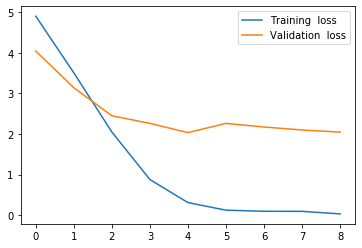

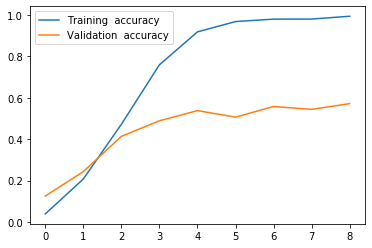

In [0]:
# Vgg Fine Tuning
history, model, validation = train(
  VGG(),
  batch_size = 32,
  epochs = 30,
  optimizer = sgd_optimizer(0.01),
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 4,
      # Information Quantity
      verbose = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

## VGG Train Only Classifier

--- Load Dataset ---
Found 7410 images belonging to 196 classes.
Found 734 images belonging to 196 classes.
--- Training Model ---
Epoch 1/30
229/229 [==============================] - 72s 315ms/step - loss: 4.4465 - acc: 0.0856 - val_loss: 3.8577 - val_acc: 0.1316
Epoch 2/30
229/229 [==============================] - 71s 311ms/step - loss: 2.5012 - acc: 0.3818 - val_loss: 3.4656 - val_acc: 0.2118
Epoch 3/30
229/229 [==============================] - 70s 306ms/step - loss: 0.9756 - acc: 0.7369 - val_loss: 3.2382 - val_acc: 0.2744
Epoch 4/30
229/229 [==============================] - 71s 309ms/step - loss: 0.2343 - acc: 0.9446 - val_loss: 3.0773 - val_acc: 0.3195
Epoch 5/30
229/229 [==============================] - 70s 305ms/step - loss: 0.0660 - acc: 0.9891 - val_loss: 3.0041 - val_acc: 0.3484
Epoch 6/30
229/229 [==============================] - 69s 302ms/step - loss: 0.0496 - acc: 0.9917 - val_loss: 2.8023 - val_acc: 0.3596
Epoch 7/30
229/229 [==============================] - 70s 3

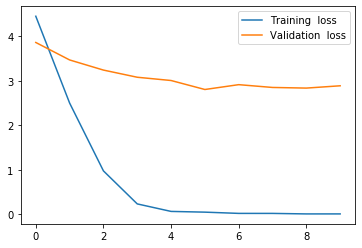

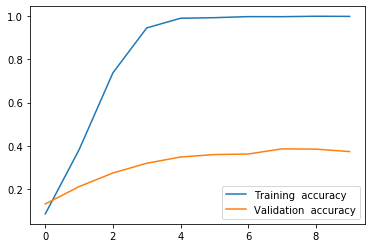

In [0]:
# Vgg All Conv Layers
history, model, validation = train(
  VGG_EXTRACTOR_ALL(),
  batch_size = 32,
  optimizer = sgd_optimizer(0.01),
  epochs = 30,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 4,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

## VGG Freeze two convolutional modules











--- Load Dataset ---
Found 7410 images belonging to 196 classes.
Found 734 images belonging to 196 classes.
--- Training Model ---


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
229/229 [==============================] - 77s 335ms/step - loss: 4.9190 - acc: 0.0383 - val_loss: 4.5225 - val_acc: 0.0702
Epoch 2/30
229/229 [==============================] - 74s 322ms/step - loss: 3.4994 - acc: 0.2020 - val_loss: 3.2269 - val_acc: 0.2406
Epoch 3/30
229/229 [==============================] - 74s 323ms/step - loss: 1.9704 - acc: 0.4924 - val_loss: 2.5225 - val_acc: 0.3922
Epoch 4/30
229/229 [==============================] - 72s 317ms/step - loss: 0.8508 - acc: 0.7687 - val_loss: 2.3730 - val_acc: 0.4336
Epoch 5/30
229/229 [==============================] - 73s 321ms/step - loss: 0.2550 - acc: 0.9349 - val_loss: 2.2912 - val_acc: 0.5113
Epoch 6/30
229/229 [==============================] - 73s 320ms/step - loss: 0.1367 - 

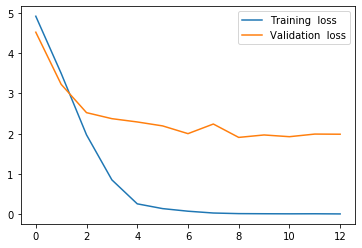

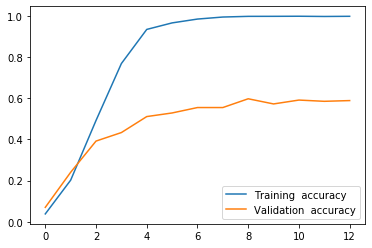

In [0]:
# Vgg Fixed Two Conv Modules
history, model, validation = train(
  VGG_EXTRACTOR_SOME(),
  batch_size = 32,
  optimizer = sgd_optimizer(0.01),
  epochs = 30,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 4,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

## VGG Fine Tuning ADAM

--- Load Dataset ---
Found 7410 images belonging to 196 classes.
Found 734 images belonging to 196 classes.
--- Training Model ---
Epoch 1/30
229/229 [==============================] - 133s 582ms/step - loss: 16.0051 - acc: 0.0042 - val_loss: 16.0575 - val_acc: 0.0038
Epoch 2/30
229/229 [==============================] - 125s 544ms/step - loss: 16.0521 - acc: 0.0041 - val_loss: 16.0575 - val_acc: 0.0038
Epoch 3/30
229/229 [==============================] - 125s 544ms/step - loss: 16.0477 - acc: 0.0044 - val_loss: 16.0575 - val_acc: 0.0038
Epoch 4/30
229/229 [==============================] - 124s 543ms/step - loss: 16.0565 - acc: 0.0038 - val_loss: 16.0373 - val_acc: 0.0050
Epoch 5/30
229/229 [==============================] - 125s 546ms/step - loss: 16.0367 - acc: 0.0050 - val_loss: 16.0373 - val_acc: 0.0050
Epoch 6/30
229/229 [==============================] - 125s 546ms/step - loss: 16.0521 - acc: 0.0041 - val_loss: 16.0777 - val_acc: 0.0025
Epoch 7/30
229/229 [=====================

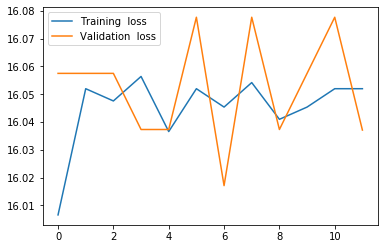

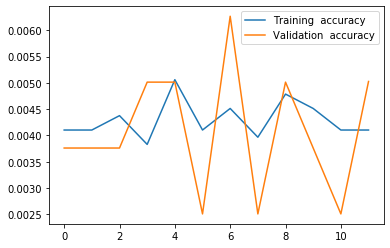

In [0]:
# Vgg
history, model, validation = train(
  VGG(),
  batch_size = 32,
  optimizer = adam_optimizer(0.001),
  epochs = 30,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 5,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

## VGG Data Augmentation











--- Load Dataset ---
Found 7410 images belonging to 196 classes.
Found 734 images belonging to 196 classes.
--- Training Model ---


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
229/229 [==============================] - 188s 823ms/step - loss: 4.9936 - acc: 0.0357 - val_loss: 4.4475 - val_acc: 0.0739
Epoch 2/30
229/229 [==============================] - 176s 769ms/step - loss: 3.9259 - acc: 0.1482 - val_loss: 3.5136 - val_acc: 0.2093
Epoch 3/30
229/229 [==============================] - 176s 767ms/step - loss: 2.6968 - acc: 0.3359 - val_loss: 3.4154 - val_acc: 0.2118
Epoch 4/30
229/229 [==============================] - 172s 749ms/step - loss: 1.7434 - acc: 0.5420 - val_loss: 1.9975 - val_acc: 0.4987
Epoch 5/30
229/229 [==============================] - 174s 759ms/step - loss: 1.1661 - acc: 0.6721 - val_loss: 1.7469 - val_acc: 0.5539
Epoch 6/30
229/229 [==============================] - 172s 752ms/step - loss: 0.7

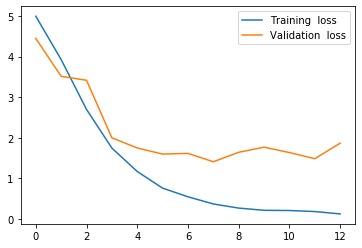

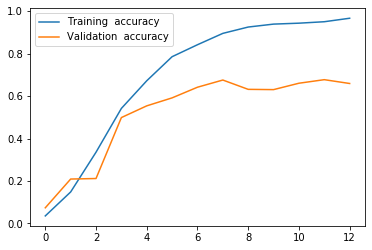

In [0]:
# Vgg
history, model, validation = train(
  VGG(),
  batch_size = 32,
  generator = complex_generator(0.1),
  optimizer = sgd_optimizer(0.01),
  epochs = 30,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 5,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

## VGG TWO FC OUTPUT + Data Augmentation













--- Load Dataset ---
Found 7410 images belonging to 196 classes.
Found 734 images belonging to 196 classes.
--- Training Model ---


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
229/229 [==============================] - 194s 849ms/step - loss: 4.6703 - acc: 0.0746 - val_loss: 3.7929 - val_acc: 0.1491
Epoch 2/30
229/229 [==============================] - 177s 771ms/step - loss: 2.5413 - acc: 0.3857 - val_loss: 2.4537 - val_acc: 0.3897
Epoch 3/30
229/229 [==============================] - 184s 805ms/step - loss: 1.2792 - acc: 0.6807 - val_loss: 1.8808 - val_acc: 0.5150
Epoch 4/30
229/229 [==============================] - 180s 788ms/step - loss: 0.6528 - acc: 0.8463 - val_loss: 1.6548 - val_acc: 0.5652
Epoch 5/30
229/229 [==============================] - 181s 792ms/step - loss: 0.3670 - acc: 0.9229 - val_loss: 1.3597 - val_acc: 0.6128
Epoch 6/30
229/229 [==============================] - 179s 783ms/step - loss: 0

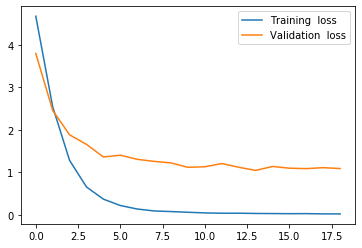

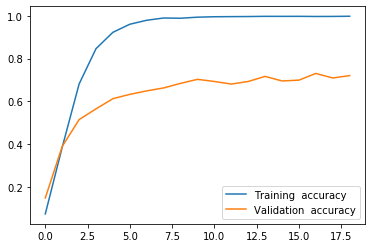

In [0]:
# Vgg Two FC output + data augmentation
history, model, validation = train(
  VGG_BATCH(),
  batch_size = 32,
  generator = complex_generator(0.1),
  optimizer = sgd_optimizer(0.01),
  epochs = 30,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 5,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

In [0]:
"""print("--- EVALUATE ---")
test = simple_generator(0.1)

test_generator = test.flow_from_directory(
  "/tmp/cars_test",
  target_size = (224, 224),
  class_mode = 'categorical',
  batch_size = 32
)

scores = model.evaluate_generator(
  test_generator,
  steps = 8041 // 5,
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
"""

## VGG TWO FC OUTPUT + Data Augmentation + 2 FC Classification 

--- Load Dataset ---
Found 7410 images belonging to 196 classes.
Found 734 images belonging to 196 classes.
--- Training Model ---
Epoch 1/30
229/229 [==============================] - 179s 780ms/step - loss: 4.7718 - acc: 0.0622 - val_loss: 4.0541 - val_acc: 0.1429
Epoch 2/30
229/229 [==============================] - 176s 768ms/step - loss: 2.7248 - acc: 0.3544 - val_loss: 2.9763 - val_acc: 0.3120
Epoch 3/30
229/229 [==============================] - 177s 772ms/step - loss: 1.3232 - acc: 0.6591 - val_loss: 2.4706 - val_acc: 0.3847
Epoch 4/30
229/229 [==============================] - 177s 771ms/step - loss: 0.6430 - acc: 0.8350 - val_loss: 1.9443 - val_acc: 0.5038
Epoch 5/30
229/229 [==============================] - 177s 775ms/step - loss: 0.3197 - acc: 0.9232 - val_loss: 1.9483 - val_acc: 0.5213
Epoch 6/30
229/229 [==============================] - 190s 831ms/step - loss: 0.2021 - acc: 0.9554 - val_loss: 1.7991 - val_acc: 0.5602
Epoch 7/30
229/229 [==============================] -

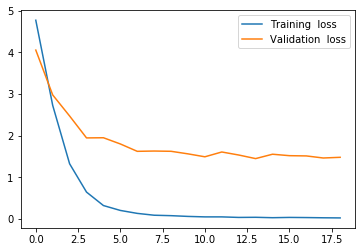

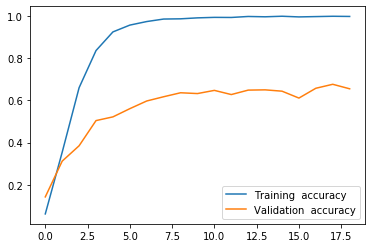

In [0]:
# Vgg Two FC output + data augmentation
history, model, validation = train(
  VGG_BATCH_CLASS_2(),
  batch_size = 32,
  generator = complex_generator(0.1),
  optimizer = sgd_optimizer(0.01),
  epochs = 30,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 5,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

## VGG + 1 CONV MODULE

In [0]:
# Vgg + data augmentation + Conv Module
history, model, validation = train(
  VGG_BATCH_CONV(),
  batch_size = 32,
  generator = complex_generator(0.1),
  optimizer = sgd_optimizer(0.01),
  epochs = 30,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 5,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

## VGG + 2 CONV MODULE

In [0]:
# Vgg + data augmentation + Conv Module
history, model, validation = train(
  VGG_BATCH_CONV_2(),
  batch_size = 32,
  generator = complex_generator(0.1),
  optimizer = sgd_optimizer(0.01),
  epochs = 30,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 5,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

## VGG + 1 CONV MODULE + 2 FC





553467904/553467096 [==============================] - 16s 0us/step








--- Load Dataset ---
Found 7410 images belonging to 196 classes.
Found 734 images belonging to 196 classes.
--- Training Model ---


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
229/229 [==============================] - 206s 901ms/step - loss: 5.3368 - acc: 0.0363 - val_loss: 4.8462 - val_acc: 0.0589
Epoch 2/30
229/229 [==============================] - 187s 815ms/step - loss: 3.7915 - acc: 0.1513 - val_loss: 4.4129 - val_acc: 0.1241
Epoch 3/30
229/229 [==============================] - 186s 814ms/step - loss: 2.6492 - acc: 0.3326 - val_loss: 3.0916 - val_acc: 0.2907
Epoch 4/30
229/229 [==============================] - 188s 821ms/step - loss: 1.7338 - acc: 0.5320 - val_loss: 2.5889 - val_acc: 0.3634
Epoch 5/30
229/229 [==============================] - 187s 819ms/step - loss: 1.0645 - acc: 0.7024 - val_loss: 2.5409 - val_acc: 0.3722
Epoch 6/30


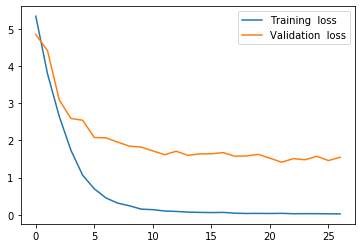

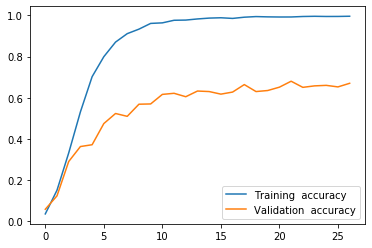

In [0]:
# Vgg Two FC output + data augmentation + Conv Module
history, model, validation = train(
  VGG_BATCH_CONV_CLASS_2(),
  batch_size = 32,
  generator = complex_generator(0.1),
  optimizer = sgd_optimizer(0.01),
  epochs = 30,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 5,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

## VGG Dropout Solo Clasificador

In [0]:
# Vgg
history, model, validation = train(
  VGG_BATCH_DROPOUT_FC(),
  batch_size = 32,
  generator = complex_generator(0.1),
  optimizer = sgd_optimizer(0.01),
  epochs = 40,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 5,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

## VGG Dropout Capas convolucionales

In [0]:
# Vgg
history, model, validation = train(
  VGG_BATCH_DROPOUT_CONV(),
  batch_size = 32,
  generator = complex_generator(0.1),
  optimizer = sgd_optimizer(0.01),
  epochs = 40,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 5,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

## VGG Skip Connection

In [0]:
# Vgg
history, model, validation = train(
  VGG_BATCH_SKIP_1(),
  batch_size = 32,
  generator = complex_generator(0.1),
  optimizer = sgd_optimizer(0.01),
  epochs = 40,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 5,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

# Modelo Final

In [0]:
# Vgg + data augmentation + Conv Module
history, model, validation = train(
  VGG_BATCH_CONV_2(),
  batch_size = 32,
  generator = complex_generator(0.1),
  optimizer = sgd_optimizer(0.01),
  epochs = 40,
  early = [
    EarlyStopping(
      # Monitorize Val Loss
      monitor  = 'val_loss',
      # Patience (Minimum number of epochs at least trains)
      patience = 5,
      # Information Quantity
      verbose  = 1,
      # Restore model weights from the epoch with the best value
      restore_best_weights = True
    ),
  ]
)

print("--- EVALUATE ---")
scores = model.evaluate_generator(
  validation,
  steps = int(8144 * 0.1),
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

show_evolution(history)

In [0]:
print("--- EVALUATE ---")
test = simple_generator(0.1)

test_generator = test.flow_from_directory(
  "/tmp/cars_test",
  target_size = (224, 224),
  class_mode = 'categorical',
  batch_size = 32
)

scores = model.evaluate_generator(
  test_generator,
  steps = 8041 // 32,
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


In [0]:
model = VGG_BATCH_CONV_2()
model.load_weights("/content/drive/My Drive/Trabajo Final VC/best_model.h5")
compiler(model, sgd_optimizer(0.01))

In [0]:
print("--- EVALUATE ---")
test = simple_generator(0.1)
test_generator = test.flow_from_directory(
  "/tmp/cars_test",
  target_size = (224, 224),
  class_mode = 'categorical',
  batch_size = 32
)

scores = model.evaluate_generator(
  test_generator,
  steps = 8041 / 32,
  verbose = 1
)

print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


--- EVALUATE ---
Found 8041 images belonging to 196 classes.
252/251 [==============================] - 98s 388ms/step
acc: 75.33%


In [0]:
# Clases
indices = test_generator.class_indices
clases = test_generator.classes
files = test_generator.filenames

# Asignamos cada Clase a su identificador
diccionario = dict((v, k) for k, v in indices.items())
 
# Predicciones
predictions = model.predict_generator(
  test_generator,
  steps = 8041 / 32,
  verbose = 1
)

predicted_classes = np.argmax(
  predictions,
  axis = 1
)

# Cogemos aquellas que están mal
errors = np.where(predicted_classes != clases)[0]

for i in range(min(len(errors), 100)):
    pred_class = np.argmax(predictions[errors[i]]) # Cogemos la fila con mayor confianza
    
    print('Original:{}, Predicho :{}, Confianza : {:.3f}'.format(
        files[errors[i]].split('/')[0], # Cogemos del path de la imagen, la clase
        diccionario[pred_class], # Cogemos la clase predicha
        predictions[errors[i]][pred_class] # Cogemos la confianza de predict_generator sobre la clase con mayor confianza
      )
    )
     
    original = load_img('/tmp/cars_test/{}'.format(files[errors[i]]))
    plt.imshow(original)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.